In [7]:
import os
import re
import email
import csv
import pandas as pd
from email import policy
from bs4 import BeautifulSoup
import hashlib
from email.utils import parseaddr
from urllib.parse import urlparse

In [1]:
# Directories of email datasets
directories = [
    "rawdata/Train Dataset/Spam Assassin/easy_ham_2",
    "rawdata/Train Dataset/Spam Assassin/hard_ham 4",
    "rawdata/Train Dataset/Spam Assassin/hard_ham 5",
    "rawdata/Train Dataset/Spam Assassin/spam 2",
    "rawdata/Train Dataset/Spam Assassin/spam_2",
    "rawdata/Train dataset/phishing3",

]

In [3]:
# MBOX path
mbox_path = "rawdata/Train Dataset/private-phishing4"


In [9]:
# Function to extract sender name, username, and domain

def extract_sender_components(sender_raw):
    name, email_addr = parseaddr(sender_raw)
    username, domain = ("", "")
    if "@" in email_addr:
        username, domain = email_addr.split("@", 1)
    return name.strip(), username.strip(), domain.strip()


In [11]:
# Function to extract URLs and split components

def extract_urls_with_parts(text):
    urls = re.findall(r'http[s]?://\S+', text)
    url_data = []
    for url in urls:
        try:
            cleaned_url = re.sub(r'[\]\)>"\']+$', '', url)
            parsed = urlparse(cleaned_url)
            url_data.append({
                "url": cleaned_url,
                "domain": parsed.netloc,
                "path": parsed.path,
                "query": parsed.query
            })
        except Exception as e:
            print(f"Failed to parse URL: {url}, Error: {e}")
    return url_data

In [13]:
# Function to extract attachments

def get_attachment_hashes(msg):
    hashes = []
    for part in msg.walk():
        if part.get_content_disposition() == "attachment":
            payload = part.get_payload(decode=True)
            if payload:
                hashes.append(hashlib.sha256(payload).hexdigest())
    return hashes

In [15]:
# Function to extract additional headers from body_text (if present)
def extract_additional_headers_and_clean_body(body):
    header_sender = ""
    message_id = ""

    lines = body.splitlines()
    cleaned_lines = []
    for line in lines:
        if line.lower().startswith("from:"):
            header_sender = line.split(":", 1)[1].strip()
        elif line.lower().startswith("message-id:"):
            message_id = line.split(":", 1)[1].strip()
        elif line.lower().startswith("date:") or line.lower().startswith("sent:"):
            continue  # Remove timestamp or sent line
        elif re.match(r'^>\s*$', line):
            continue  # Remove quoted empty lines
        elif re.match(r'^(from|date|subject|to|cc|bcc):', line.strip(), re.IGNORECASE):
            continue  # Remove common header lines in body
        else:
            cleaned_lines.append(line)

    cleaned_body = "\n".join(cleaned_lines).strip()
    return header_sender, message_id, cleaned_body

In [17]:
# Function to determine email safety
def determine_mail_safety(directory):
    directory = directory.lower()
    if "easy_ham" in directory or "hard_ham" in directory:
        return 1
    elif "spam" in directory or "phishing" in directory:
        return 0
    return -1


In [19]:
# Parse single email
def parse_eml(file_path, email_id, directory):
    with open(file_path, "r", encoding="latin-1") as f:
        msg = email.message_from_file(f, policy=policy.compat32)

    raw_sender = msg.get("From", "Unknown")
    name, username, domain = extract_sender_components(raw_sender)

    # Additional headers
    subject = msg.get("Subject", "")
    reply_to = msg.get("Reply-To", "")
    x_mailer = msg.get("X-Mailer", "")
    return_path = msg.get("Return-Path", "")
    received = msg.get("Received", "")

    # Extract body
    body = ""
    if msg.is_multipart():
        for part in msg.walk():
            if part.get_content_type() == "text/plain":
                body = part.get_payload(decode=True).decode(errors="ignore")
                break
            elif part.get_content_type() == "text/html" and not body:
                body = BeautifulSoup(part.get_payload(decode=True), "html.parser").get_text()
    else:
        body = msg.get_payload(decode=True).decode(errors="ignore")

    header_sender, message_id, cleaned_body = extract_additional_headers_and_clean_body(body)

    urls = extract_urls_with_parts(cleaned_body)
    attachments = get_attachment_hashes(msg)
    mail_is_safe = determine_mail_safety(directory)

    entries = []

    for url_info in urls:
        entries.append({
            "id": email_id,
            "name": name,
            "username": username,
            "mail_domain": domain,
            "header_sender": header_sender,
            "message_id": message_id,
            "subject": subject,
            "reply_to": reply_to,
            "x_mailer": x_mailer,
            "return_path": return_path,
            "received": received,
            "body_text": cleaned_body,
            "body_count_of_words": len(cleaned_body.split()),
            "body_length": len(cleaned_body),
            "has_url": 1,
            "url_count": len(urls),
            "url": url_info["url"],
            "url_domain": url_info["domain"],
            "url_path": url_info["path"],
            "url_query": url_info["query"],
            "url_is_safe": "",
            "has_attachment": 1 if attachments else 0,
            "attachment_count": len(attachments),
            "attachment_hash": "",
            "attachment_is_safe": "",
            "mail_is_safe": mail_is_safe
        })

    for hash_val in attachments:
        entries.append({
            "id": email_id,
            "name": name,
            "username": username,
            "mail_domain": domain,
            "header_sender": header_sender,
            "message_id": message_id,
            "subject": subject,
            "reply_to": reply_to,
            "x_mailer": x_mailer,
            "return_path": return_path,
            "received": received,
            "body_text": cleaned_body,
            "body_count_of_words": len(cleaned_body.split()),
            "body_length": len(cleaned_body),
            "has_url": 1 if urls else 0,
            "url_count": len(urls),
            "url": "",
            "url_domain": "",
            "url_path": "",
            "url_query": "",
            "url_is_safe": "",
            "has_attachment": 1,
            "attachment_count": len(attachments),
            "attachment_hash": hash_val,
            "attachment_is_safe": "",
            "mail_is_safe": mail_is_safe
        })

    return entries

In [21]:
def parse_mbox(mbox_path, start_id, mail_is_safe=0):
    import mailbox
    from bs4 import BeautifulSoup

    mbox = mailbox.mbox(mbox_path)
    rows = []
    email_id = start_id

    for msg in mbox:
        try:
            sender_info = extract_sender_components(msg)

            body = ""
            if msg.is_multipart():
                for part in msg.walk():
                    content_type = part.get_content_type()
                    if content_type == "text/plain":
                        body += part.get_payload(decode=True).decode(errors="ignore")
                    elif content_type == "text/html" and not body:
                        body += BeautifulSoup(part.get_payload(decode=True), "html.parser").get_text()
            else:
                body = msg.get_payload(decode=True).decode(errors="ignore")

            headers, cleaned_body = extract_additional_headers_and_clean_body(body)
            urls = extract_urls_with_parts(cleaned_body)
            attachments = get_attachment_hashes(msg)

            max_items = max(len(urls), len(attachments), 1)
            for i in range(max_items):
                url_data = urls[i] if i < len(urls) else {"url": "", "domain": "", "path": "", "query": ""}
                attachment = attachments[i] if i < len(attachments) else ""

                rows.append({
                    "id": email_id,
                    "name": sender_info["name"],
                    "username": sender_info["username"],
                    "mail_domain": sender_info["mail_domain"],
                    **headers,
                    "body_text": cleaned_body,
                    "body_count_of_words": len(cleaned_body.split()),
                    "body_length": len(cleaned_body),
                    "has_url": 1 if urls else 0,
                    "url_count": len(urls),
                    "url": url_data["url"],
                    "url_domain": url_data["domain"],
                    "url_path": url_data["path"],
                    "url_query": url_data["query"],
                    "url_is_safe": "",
                    "has_attachment": 1 if attachments else 0,
                    "attachment_count": len(attachments),
                    "attachment_hash": attachment,
                    "attachment_is_safe": "",
                    "mail_is_safe": mail_is_safe
                })
            email_id += 1
        except Exception as e:
            email_id += 1
    return rows, email_id


In [23]:
def process_emails():
    output_file = "data/train_email.csv"
    fieldnames = [
        "id", "name", "username", "mail_domain", "header_sender", "message_id",
        "subject", "reply_to", "x_mailer", "return_path", "received",
        "body_text", "body_count_of_words", "body_length",
        "has_url", "url_count", "url", "url_domain", "url_path", "url_query", "url_is_safe",
        "has_attachment", "attachment_count", "attachment_hash", "attachment_is_safe",
        "mail_is_safe"
    ]

    email_id = 1

    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Process EML files
        for directory in directories:
            for file in sorted(os.listdir(directory)):
                file_path = os.path.join(directory, file)
                if os.path.isfile(file_path):
                    entries = parse_eml(file_path, email_id, directory)
                    for entry in entries:
                        writer.writerow(entry)
                    email_id += 1

        # Process single MBOX file
        mbox_rows, email_id = parse_mbox(mbox_path, email_id, mail_is_safe=0)
        for row in mbox_rows:
            writer.writerow(row)

    print(f"Train dataset feature extraction complete. Output saved to {output_file}")


In [25]:
# Run the process
process_emails()

Train dataset feature extraction complete. Output saved to data/train_email.csv


In [26]:
import pandas as pd

csv_file = "data/train_email.csv"
df = pd.read_csv(csv_file, low_memory=False)

phish_df = df.query("mail_is_safe == 0")
safe_df = df.query("mail_is_safe == 1")

print(f"Phishing Emails: {(phish_df['mail_is_safe'] == 0).sum()}")
print(f"1. With URLs: {phish_df['has_url'].sum()}")
print(f"2. Without URLs: {(phish_df['has_url'] == 0).sum()}")
print(f"3. With Attachments: {phish_df['has_attachment'].sum()}")
print(f"4. Without Attachments: {(phish_df['has_attachment'] == 0).sum()}")

print(f"\nSafe Emails: {(safe_df['mail_is_safe'] == 1).sum()}")
print(f"1. With URLs: {safe_df['has_url'].sum()}")
print(f"2. Without URLs: {(safe_df['has_url'] == 0).sum()}")
print(f"3. With Attachments: {safe_df['has_attachment'].sum()}")
print(f"4. Without Attachments: {(safe_df['has_attachment'] == 0).sum()}")

print("\nDetailed Phishing Email Breakdown:")
print(f"- Emails with URLs and Attachments: {len(phish_df.query('has_url == 1 and has_attachment == 1'))}")
print(f"- Emails without URLs but with Attachments: {len(phish_df.query('has_url == 0 and has_attachment == 1'))}")
print(f"- Emails with URLs but without Attachments: {len(phish_df.query('has_url == 1 and has_attachment == 0'))}")


Phishing Emails: 25621
1. With URLs: 25600
2. Without URLs: 21
3. With Attachments: 55
4. Without Attachments: 25566

Safe Emails: 43390
1. With URLs: 43384
2. Without URLs: 6
3. With Attachments: 16
4. Without Attachments: 43374

Detailed Phishing Email Breakdown:
- Emails with URLs and Attachments: 34
- Emails without URLs but with Attachments: 21
- Emails with URLs but without Attachments: 25566


## Feature Correlation

In [76]:
pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


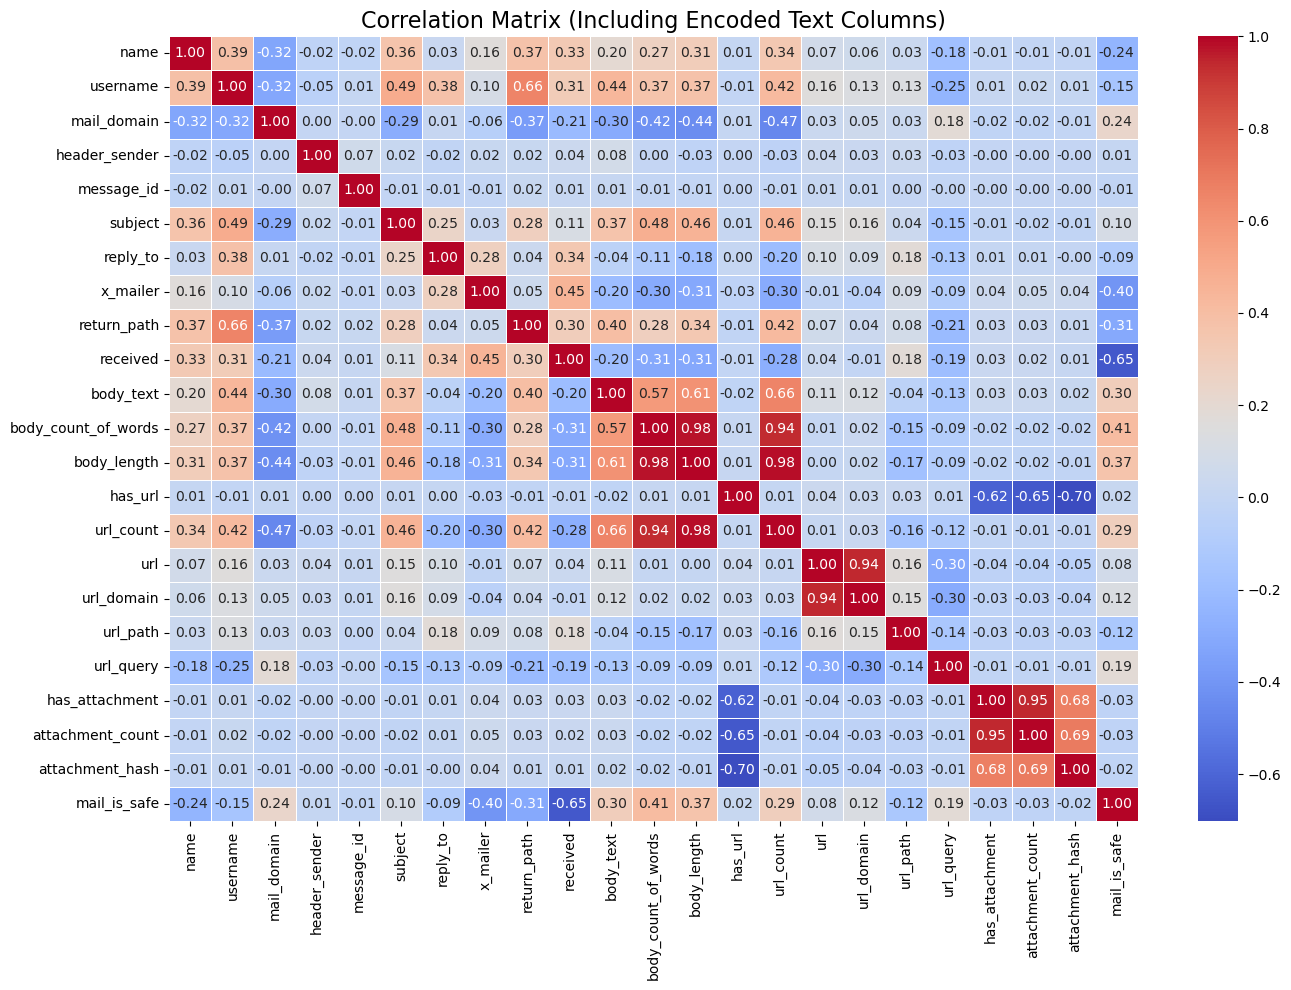

In [30]:
## Liniear dependencies - Correlation Matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Convert all object (textual) columns to category codes
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Drop irrelevant columns from correlation analysis
exclude_cols = ["id", "url_is_safe", "attachment_is_safe"]
df_encoded = df_encoded.drop(columns=exclude_cols, errors='ignore')

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

#Plot Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix (Including Encoded Text Columns)", fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
#  Non-Linear dependencies - Mutual Information Score

In [102]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


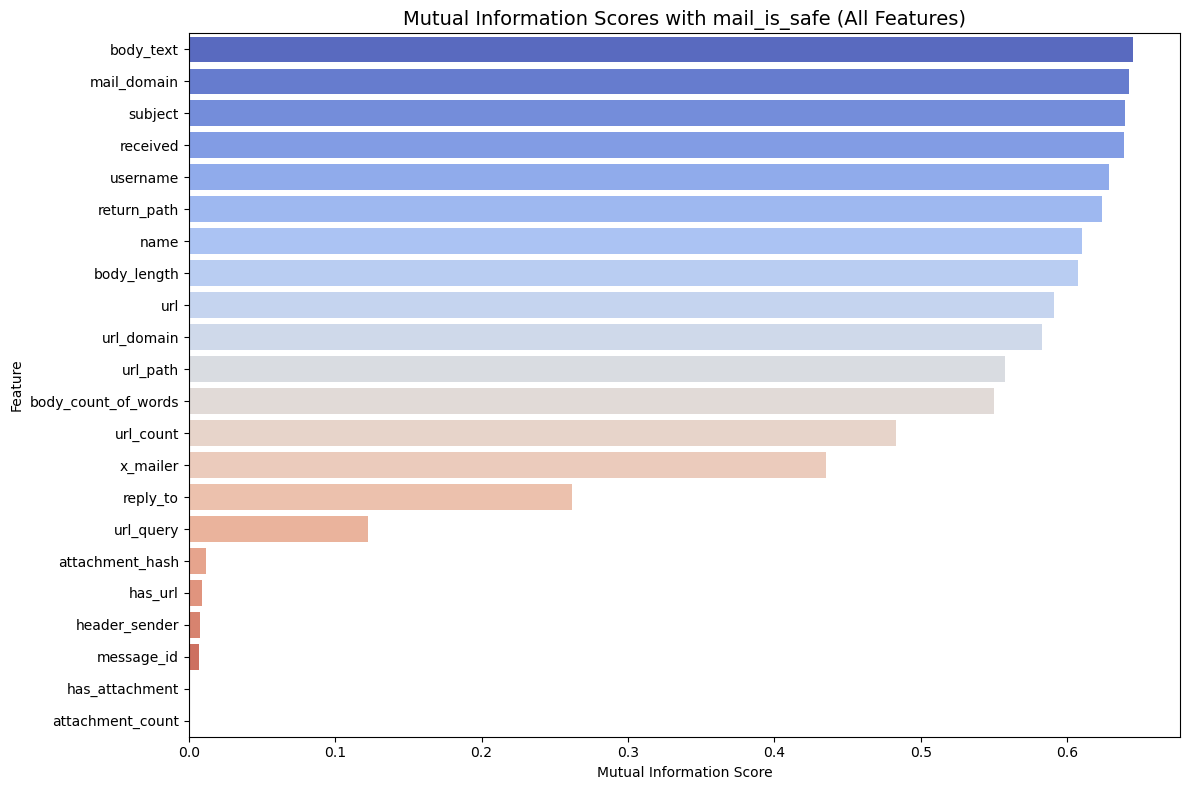

In [58]:
from sklearn.feature_selection import mutual_info_classif


# Drop irrelevant columns
excluded_cols = ["id", "url_is_safe", "attachment_is_safe", "mail_is_safe"]
df_filtered = df.drop(columns=excluded_cols, errors='ignore')

# Encode categorical/text columns
for col in df_filtered.select_dtypes(include=['object']).columns:
    df_filtered[col] = df_filtered[col].astype("category").cat.codes

# Target variable
y = df["mail_is_safe"]

# Compute mutual information
mi_scores = mutual_info_classif(df_filtered, y, discrete_features='auto', random_state=0)

# Convert to Series for easy plotting
mi_series = pd.Series(mi_scores, index=df_filtered.columns)
mi_series = mi_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    x=mi_series.values,
    y=mi_series.index,
    hue=mi_series.index,
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.title("Mutual Information Scores with mail_is_safe (All Features)", fontsize=14)
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

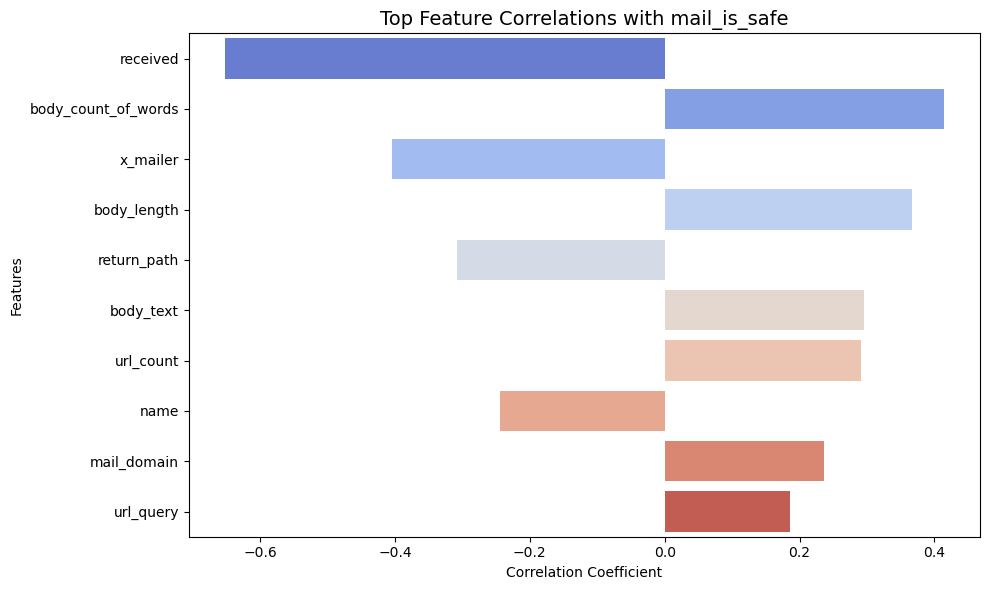

In [36]:
# Top feature correlation with mail_is_safe
target_corr = correlation_matrix["mail_is_safe"].drop(labels=["mail_is_safe", "id", "url_is_safe", "attachment_is_safe"], errors="ignore")

# Sort by absolute correlation (strongest first)
target_corr = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Plot top N correlations with mail_is_safe (future-proof)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=target_corr.head(10).values,
    y=target_corr.head(10).index,
    hue=target_corr.head(10).index,
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.title("Top Feature Correlations with mail_is_safe", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout()
plt.show()